# Assignment 4 - Structure Learning
## Probabilistic Models UE
### WS 2017

---
<div class="alert alert-warning">
**Due:** 12.12.2017, 11:00
</div>
<div class="alert alert-info">
**HINT**: This notebook contains many functions that will help you in solving this assignment. There is also a short description of how the struture of a Bayesien network will be prepresented. *Read the functions and the description carefully, and make sure you understand them*. This will be crucial in order to complete this exercise. If you have any questions, remember the MOODLE forum and/or contact us directly.
</div>

<div class="alert alert-info">
**ADDITIONAL LIBRARIES**: To print the network structure, you will need the ```networkx``` library installed. If you use the Anaconda Python distribution, just use the following command:
```
   conda install networkx
```
</div>

---

## Representing the Network Structure

In this assignment, you will implement a function that learns the structure of a Bayesian net using search in a restricted state space. The restriction is defined by **variable ordering**.

Since we are dealing with a variable structure, we need to store it in some way. We do it using two lists:
  - One list contains the (conditional) probability tables (CPTs) of the variables; this list will usually be called ```dists``` in this notebook.
  - The second list contains lists of indices that denote to which columns in the data the dimensions of the corresponding CPTs belong to as lists. This list will usually be called ```indices``` in this notebook.
  
For example, assume we have three random variables A, B, and C. The data is stored accordingly. Further assume we want to encode the model that factorises in the following way:

$$ P(A, B, C) = P(A) \cdot P(B \mid A) \cdot P(C \mid A, B).$$

Variables $A, B$ and $C$ will get indcies 0, 1, and 2 respectively. The two lists will then look like this (following the same naming conventions as used in the previous exercises):

```python
dists = [A, B_A, C_AB]
indices = [[0], [1, 0], [2, 0, 1]]
```

## Passing functions as parameters

In Python, functions are [first-class citizens](https://en.wikipedia.org/wiki/First-class_function). This means, you can pass them as parameters to other functions:

In [1]:
def my_foo(func):
    print func(3)

def my_bar(num):
    return 'bar {}'.format(num)

def my_baz(num):
    return 'baz {}'.format(num)

my_foo(my_bar)
my_foo(my_baz)

bar 3
baz 3


We will use this to pass different ```score``` functions to the ```learn_net``` function.

---

# 1. Structure Learning

Consider the same model as in assignment 3, comprising the following random
variables:

- S ... stress 
- E ... easily catches cold  
- G ... genetic disposition 
- I ... increased blood pressure
- H ... heart attack

Instead of trying different model structures manually, our medicine freshman
wants the computer to determine the best structure automatically. To this end,
she asks her computer science colleagues to get even more data from the
university clinic systems, and they give her four data sets of different sizes
(see ''train\_small.txt'', ''train\_medium.txt'', ''train\_big.txt'', and
''test.txt'').

She decides to use *score-based search* to find the best model. She wants
to *define a variable order* to strongly restrict the search space.

## 1.1 Learn the network structure and parameters (15 points)

Implement a function that learns the *structure* and *parameters* of a Bayesian net using *score-based search over a search space restricted by a pre-determined variable order*. To do this, put your code in the ```learn_net``` function in this notebook, and make it return the model in the format described above. To help you with this task, we provide you with a number of helper functions. *Make sure to read their docstrings and understand what they are doing*. You can add more helper functions if you need them.

In [2]:
from __future__ import print_function
%pylab inline
import itertools as it
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


### Helper Functions

In [3]:
def mle(data, var, parents=None, laplace=1):
    """
    Does maximum likelihood estimation of the (conditional) probability distribution
    of a random variable given the data.
    
    :param data:    data to use for estimating the distribution
    :param var:     index of the variable to estimate the distribution for
    :param parents: parents (ids of given variables) of the variable in the Bayes net,
                    given as list. If None or of length 0, the variable is assumed to have no parents.
    :param laplace: laplace smoothing with this alpha.
    :return:        Estimated (conditional) probability distribution of the random variable
    """
    parents = parents or []
    parents = list(parents)
    n_vars = len(parents) + 1
    
    Y = data[:, [var] + parents]
    X = empty((2,) * n_vars)
    
    for vals in it.product([0, 1], repeat=n_vars):
        X[vals] = np.sum(np.all(Y == vals, axis=1))
        
    X += laplace
    
    return X / X.sum(0)


def log_likelihood(data, dists, indices):
    """
    Computes the log likelihood of the data given a model. A model is given as a list
    of distributions (conditional probability tables) and corresponding indices describing
    which dimension of each distribution corresponds to which random variable. E.g., 
    assume you have data for three random variables A, B and C given in alphabetical order.
    If dists looks like [A_B, B, C_AB], indices would be [(0, 1), (1,), (2, 0, 1)].
    
    :param data:    data to compute the log-likelihood of
    :param dists:   list of (conditional) probability tables for the random variables
    :param indices: list of variable indices corresponding to the CPTs stored in 'dists'
    :return:        log-likelihood of data given the model as encoded by dists and indices
    """
    log_l = 0
    for y in data:
        for i in range(len(dists)):
            idx = indices[i]
            log_l += log(dists[i][tuple(y[idx])])
            
    return log_l


def mean_log_likelihood(data, dists, indices):
    """
    Computes the mean log likelihood of each data point in data.
    
    :param data:    data to compute the log-likelihood of
    :param dists:   list of (conditional) probability tables for the random variables
    :param indices: list of variable indices corresponding to the CPTs stored in 'dists'
    :return:        mean log-likelihood of data given the model as encoded by dists and indices
    """
    return log_likelihood(data, dists, indices) / len(data)



def bic(data, dists, indices):
    """
    Computes the Bayesian information criterion assuming a Dirichlet prior over the model
    parameters.
    
    :param data:    data to compute the Bayesian information criterion on
    :param dists:   list of (conditional) probability tables for the random variables
    :param indices: list of variable indices corresponding to the CPTs stored in 'dists'
    :return:        BIC score
    """
    # TODO: Implement this
    
    first_term = log_likelihood(data, dists, indices)
    
    M = sum(2**(len(i) - 1) for i in indices)
        
    second_term = (log(data.shape[0])/2)*M
     
    BIC_Score = first_term - second_term
    
    return BIC_Score

### Function to learn the network

In [4]:
import itertools
def compute_perm(S, k = 1):
    if k > len(S):
        return set() 
    else:
        return list(set(itertools.combinations(S, k)).union( compute_perm(S, k+1) ))

In [5]:
def learn_net(data, score, var_ord):
    """
    Learns the structure and parameters of a Bayesian network.
    
    :param data:    data to learn the network from. Each column corresponds to a random variable
    :param score:   which score function to use. the score function takes three parameters (distribution list, index list, data)
    :param var_ord: ordering of the variables, defines how the search space is restricted. If None, use the column order in the data.
    :return:        tuple of two lists: one holds the distributions, the other the indices of the random variables the
                    distributions represent
    """
    
    
    dists = [mle(data,i,None) for i in range(len(var_ord))] 
    indices = [[i] for i in range(len(var_ord))]
    
    score_max = score(data,dists,indices)
    for i in range(len(var_ord)):
        curr_var = var_ord[i]
        permutations = compute_perm(var_ord[0:i])
        all_mle_of_var = []
        
        all_scores = []
        current_dist = list(dists)
        current_indices = list(indices)
        #looping on the permutations
        for k in permutations:
            k = list(k)
            current_dist[curr_var] = mle(data,curr_var,k)
            current_indices[curr_var] = [curr_var]+k
            score_res = score(data,current_dist,current_indices)
            
            if score_max<score_res:
                score_max = score_res
                dists = list(current_dist)
                indices = list(current_indices)
                
    
    return dists, indices

## 1.2 Implement a function that learns the parameters of a model with a predefined structure (2 points)

Use the same structure as in Assignment 3, Model 2: $P(S)$, $P(E \mid S)$, $P(G)$, $P(I \mid G, S)$, $P(H \mid I)$. You solved this in principle in the previous assignment, but make sure this function returns a model description in the format described in the beginning of this notebook!

In [6]:
def learn_params(data):

    dists = []
    indices = [[0],[1,0],[2],[3,0,2],[4,3]]
    
    dists.append(mle(data, 0,None))
    dists.append(mle(data, 1, [0]))
    dists.append(mle(data, 2))
    dists.append(mle(data, 3, [0, 2]))
    dists.append(mle(data, 4, [3]))
    
    return dists, indices

---
# 2. Comparison

Compare the following learning configurations for *each of the training datasets* (small, medium, big):

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Variable Order</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Score Function</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">S, E, G, I, H</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">H, I, G, E, S</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">I, S, E, H, G<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">S, E, G, I, H</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Log-Likelihood</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Pre-defined network structure</td></tr></table>

For comparison, compute the log-likelihood of the used training data and of the test data, and plot the network structures. In the end, plot the log-likelihood of the test data for each training configuration depending on the size of the training dataset.

<center><br>**Code for this is already in this notebook! Just run it! This exercise is about interpretation (see bottom of the notebook).**</center>

### Load Data

In [7]:
Y_train_small = loadtxt('train_small.txt', dtype=int)
Y_train_medium = loadtxt('train_medium.txt', dtype=int)
Y_train_big = loadtxt('train_big.txt', dtype=int)
Y_test = loadtxt('test.txt', dtype=int)

### Helper Functions for Evaluation and Drawing
<br>
<div class="alert alert-info">
**HINT**: In the Bayesian network graphs, the thicker end of the edges indicates the arrow pointer!
</div>

In [8]:
def draw_graph(indices):
    """
    Draw the Bayesian net. Arrows are indicated by edges getting bolder.
    :param indices:  indices defining the structure of the net, as returned by the learn functions
    """
    node_names = ['S', 'E', 'G', 'I', 'H']
    G = nx.DiGraph()
    G.add_nodes_from(node_names)
    
    for i in indices:
        for p in i[1:]:
            G.add_edge(node_names[p], node_names[i[0]])
            
    # fixed position for the nodes
    pos = {'S': [0., 3.],
           'E': [.5, 3.],
           'G': [.75, 2.5],
           'I': [0., 2.],
           'H': [.5, 2.]
    }
    
    nx.draw(G, pos=pos, with_labels=True, node_size=3000, node_color='gray')
    
def evaluate_net(net, train_set, test_set):
    train_logl = mean_log_likelihood(train_set, *net)
    test_logl = mean_log_likelihood(test_set, *net)
    print('Avg. train log-likelihood:', train_logl)
    print('Avg. test log-likelihood:', test_logl)
    display(draw_graph(net[1]))
    return train_logl, test_logl

### Small Train Set / Pre-defined structure

Avg. train log-likelihood: -1.8449746715
Avg. test log-likelihood: -1.81992526697


None

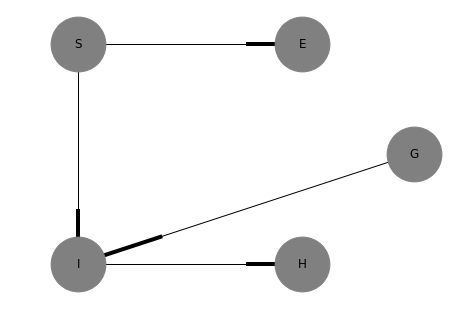

In [9]:
sm_gs_train_logl, sm_gs_test_logl = evaluate_net(
    learn_params(Y_train_small),
    Y_train_small,
    Y_test
)

### Small Train Set / Standard Variable Order

Avg. train log-likelihood: -1.84883495897
Avg. test log-likelihood: -1.82967723389


None

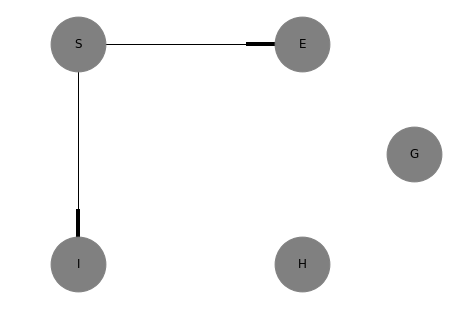

In [10]:
sm_ord_train_logl, sm_ord_test_logl = evaluate_net(
    learn_net(Y_train_small, score=bic, var_ord=range(5)),
    Y_train_small, 
    Y_test
)

### Small Train Set / Reverse Variable Order

Avg. train log-likelihood: -1.85103003022
Avg. test log-likelihood: -1.83144664735


None

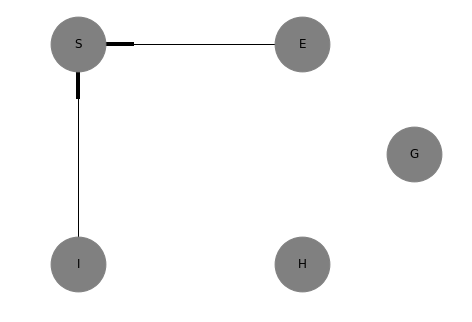

In [11]:
sm_rev_train_logl, sm_rev_test_logl = evaluate_net(
    learn_net(Y_train_small, score=bic, var_ord=range(5)[::-1]),
    Y_train_small, 
    Y_test
)

### Small Train Set / "Random" Variable Order

Avg. train log-likelihood: -1.84883366104
Avg. test log-likelihood: -1.82968277566


None

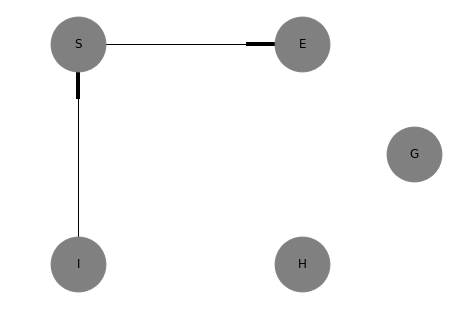

In [12]:
sm_rnd_train_logl, sm_rnd_test_logl = evaluate_net(
    learn_net(Y_train_small, score=bic, var_ord=[3, 0, 1, 4, 2]),
    Y_train_small, 
    Y_test
)

### Small Train Set / Standard Order, Log-Likelihood Score

Avg. train log-likelihood: -1.83830973984
Avg. test log-likelihood: -1.82566091307


None

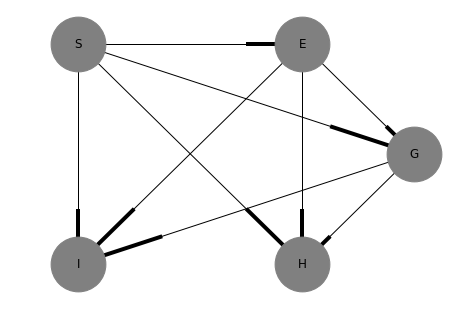

In [13]:
sm_ord_ll_train_logl, sm_ord_ll_test_logl = evaluate_net(
    learn_net(Y_train_small, score=log_likelihood, var_ord=range(5)),
    Y_train_small, 
    Y_test
)

### Medium Train Set / Pre-defined Structure

Avg. train log-likelihood: -1.86709429351
Avg. test log-likelihood: -1.81748715738


None

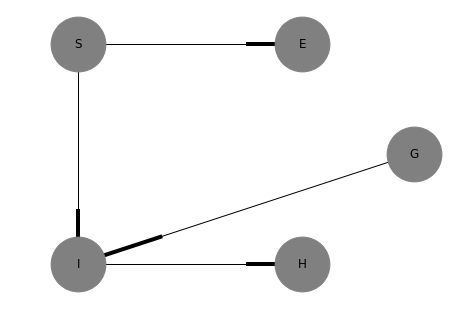

In [14]:
md_gs_train_logl, md_gs_test_logl = evaluate_net(
    learn_params(Y_train_medium),
    Y_train_medium,
    Y_test
)

### Medium Train Set / Standard Variable Order

Avg. train log-likelihood: -1.86709429351
Avg. test log-likelihood: -1.81748715738


None

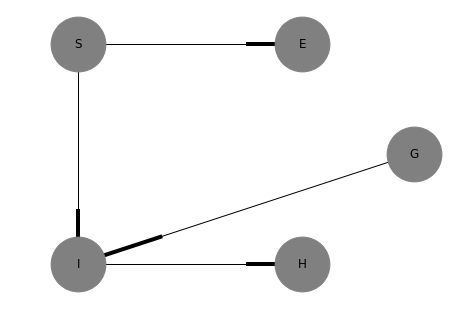

In [15]:
md_ord_train_logl, md_ord_test_logl = evaluate_net(
    learn_net(Y_train_medium, score=bic, var_ord=range(5)),
    Y_train_medium,
    Y_test
)

### Medium Train Set / Reverse Variable Order

Avg. train log-likelihood: -1.8680731923
Avg. test log-likelihood: -1.82152483825


None

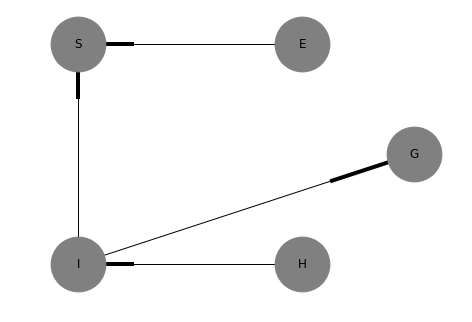

In [16]:
md_rev_train_logl, md_rev_test_logl = evaluate_net(
    learn_net(Y_train_medium, score=bic, var_ord=range(5)[::-1]),
    Y_train_medium,
    Y_test
)

### Medium Train Set / "Random" Variable Order

Avg. train log-likelihood: -1.86706461432
Avg. test log-likelihood: -1.81750134643


None

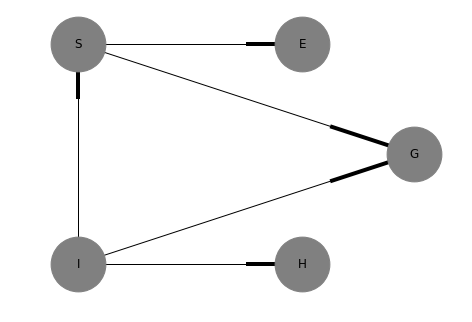

In [17]:
md_rnd_train_logl, md_rnd_test_logl = evaluate_net(
    learn_net(Y_train_medium, score=bic, var_ord=[3, 0, 1, 4, 2]),
    Y_train_medium,
    Y_test
)

### Medium Train Set / Standard Order, Log-Likelihood Score

Avg. train log-likelihood: -1.86517928806
Avg. test log-likelihood: -1.81951804021


None

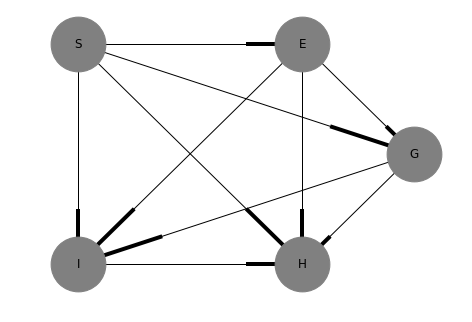

In [18]:
md_ord_ll_train_logl, md_ord_ll_test_logl = evaluate_net(
    learn_net(Y_train_medium, score=log_likelihood, var_ord=range(5)),
    Y_train_medium,
    Y_test
)

### Big Train Set / Pre-defined Structure

Avg. train log-likelihood: -1.8353407604
Avg. test log-likelihood: -1.8167549423


None

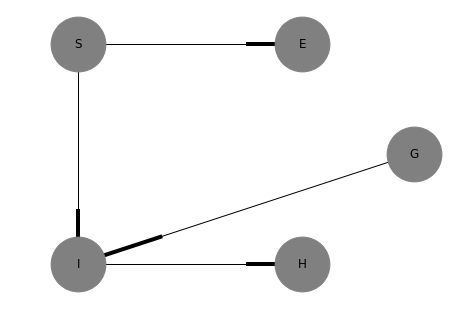

In [19]:
bg_gs_train_logl, bg_gs_test_logl = evaluate_net(
    learn_params(Y_train_big),
    Y_train_big,
    Y_test
)

### Big Train Set / Standard Variable Order

Avg. train log-likelihood: -1.8353407604
Avg. test log-likelihood: -1.8167549423


None

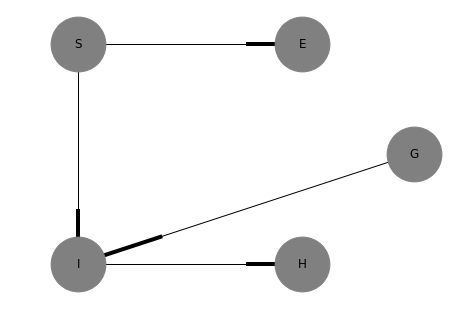

In [20]:
bg_ord_train_logl, bg_ord_test_logl = evaluate_net(
    learn_net(Y_train_big, score=bic, var_ord=range(5)),
    Y_train_big,
    Y_test
)

### Big Train Set / Reverse Variable Order

Avg. train log-likelihood: -1.83550230372
Avg. test log-likelihood: -1.81672228257


None

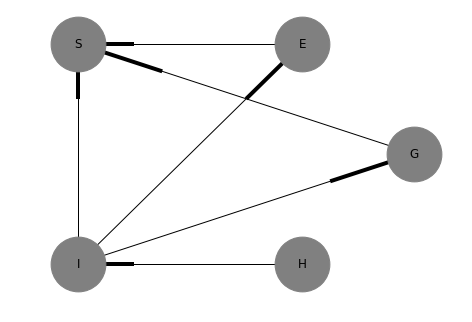

In [21]:
bg_rev_train_logl, bg_rev_test_logl = evaluate_net(
    learn_net(Y_train_big, score=bic, var_ord=range(5)[::-1]),
    Y_train_big,
    Y_test
)

### Big Train Set / "Random" Variable Order

Avg. train log-likelihood: -1.83529425059
Avg. test log-likelihood: -1.81683207014


None

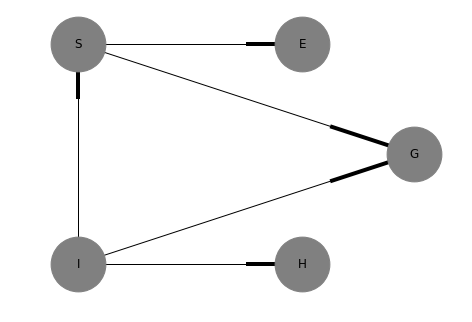

In [22]:
bg_rnd_train_logl, bg_rnd_test_logl = evaluate_net(
    learn_net(Y_train_big, score=bic, var_ord=[3, 0, 1, 4, 2]),
    Y_train_big,
    Y_test
)

### Big Train Set / Standard Variable Order, Log-Likelihood Score

Avg. train log-likelihood: -1.83488183354
Avg. test log-likelihood: -1.8171836297


None

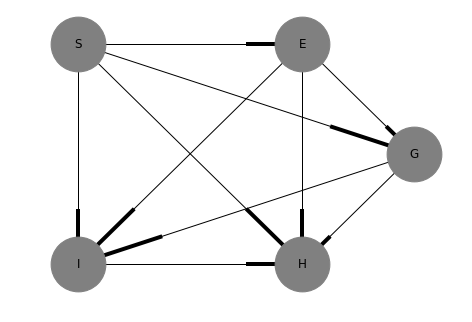

In [23]:
bg_ord_ll_train_logl, bg_ord_ll_test_logl = evaluate_net(
    learn_net(Y_train_big, score=log_likelihood, var_ord=range(5)),
    Y_train_big,
    Y_test
)

## Plots - Variable Order

First, we compare the results of the different variable orders with the given network (with learned parameters) and the network learnt with log-likelihood score, for each dataset size.

In [24]:
def plot_compare_orders(train_losses, test_losses, title):
    f = plt.figure(figsize=(15, 5))
    f.suptitle(title, fontsize=15)
    ax = f.add_subplot(121)
    ax.plot(train_losses, marker='d')
    ax.set_xlim(-0.25, len(train_losses) - 0.75)
    ax.set_title('Log-Likelihood train data')
    ax.set_xticks(range(len(train_losses)))
    ax.set_xticklabels(['Pre-def', 'Ord', 'Rev', 'Rnd', 'Ord-LL'])
    ax = f.add_subplot(122)
    ax.plot(test_losses, marker='d', color='g')
    ax.set_xlim(-0.25, len(train_losses) - 0.75)
    ax.set_title('Log-Likelihood test data')
    ax.set_xticks(range(len(train_losses)))
    ax.set_xticklabels(['Pre-def', 'Ord', 'Rev', 'Rnd', 'Ord-LL'])

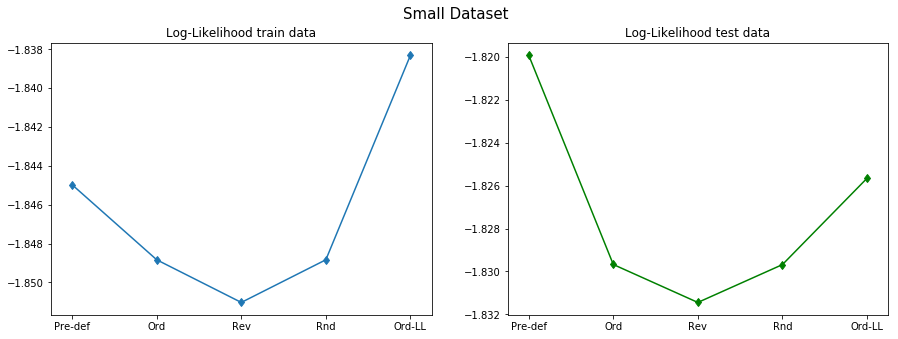

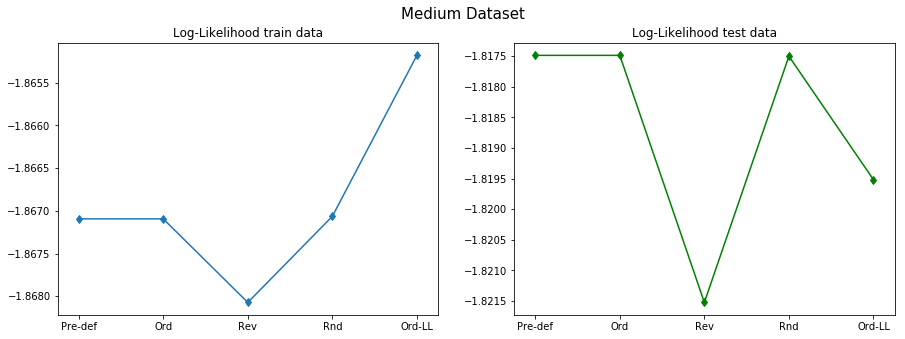

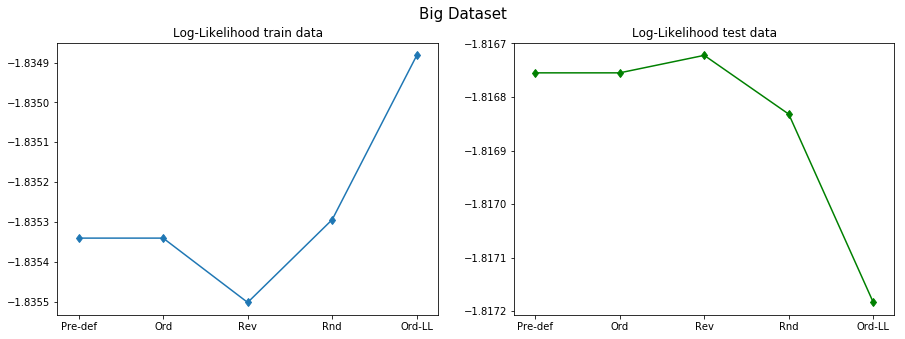

In [25]:
plot_compare_orders([sm_gs_train_logl, sm_ord_train_logl, sm_rev_train_logl, sm_rnd_train_logl, sm_ord_ll_train_logl],
                    [sm_gs_test_logl, sm_ord_test_logl, sm_rev_test_logl, sm_rnd_test_logl, sm_ord_ll_test_logl],
                    'Small Dataset')

plot_compare_orders([md_gs_train_logl, md_ord_train_logl, md_rev_train_logl, md_rnd_train_logl, md_ord_ll_train_logl],
                    [md_gs_test_logl, md_ord_test_logl, md_rev_test_logl, md_rnd_test_logl, md_ord_ll_test_logl],
                    'Medium Dataset')

plot_compare_orders([bg_gs_train_logl, bg_ord_train_logl, bg_rev_train_logl, bg_rnd_train_logl, bg_ord_ll_train_logl],
                    [bg_gs_test_logl, bg_ord_test_logl, bg_rev_test_logl, bg_rnd_test_logl, bg_ord_ll_test_logl],
                    'Big Dataset')

## Plots - Compare Test Set Performance given Train Set Size

In [45]:
def compare_train_size(given_test_loss, ord_test_loss, rev_test_loss, rnd_test_loss, ord_ll_test_loss):
    plt.figure(figsize=(15, 10))
    plt.plot(ord_test_loss, marker='d', label='ordered')
    plt.plot(rev_test_loss, marker='d', label='reverse')
    plt.plot(rnd_test_loss, marker='d', label='random')
    plt.plot(ord_ll_test_loss, marker='d', label='ordered log-l')
    plt.plot(given_test_loss, marker='d', label='given structure')
    plt.xlim(-0.25, 2.25)
    plt.xticks([0, 1, 2], ['Small', 'Medium', 'Large'])
    plt.ylabel('Test Data Log-Likelihood')
    plt.xlabel('Train Set')
    plt.legend(loc='best')

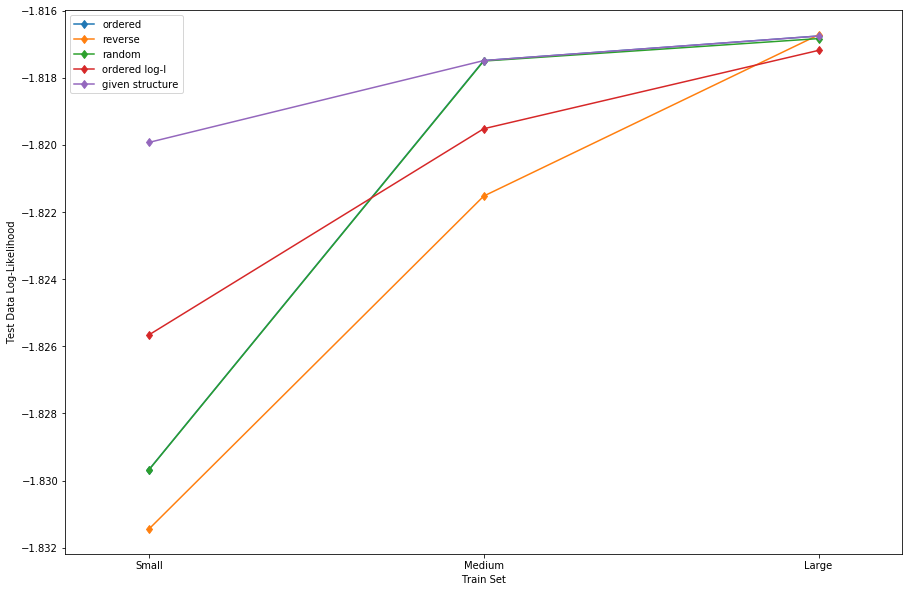

In [46]:
compare_train_size([sm_gs_test_logl, md_gs_test_logl, bg_gs_test_logl],
                   [sm_ord_test_logl, md_ord_test_logl, bg_ord_test_logl],
                   [sm_rev_test_logl, md_rev_test_logl, bg_rev_test_logl],
                   [sm_rnd_test_logl, md_rnd_test_logl, bg_rnd_test_logl],
                   [sm_ord_ll_test_logl, md_ord_ll_test_logl, bg_ord_ll_test_logl],
                   )

## 2.1 Interpret the Results in Detail (6 points)

Answer the following questions, and use them as inspiration to analyse the results more deeply.

 - What is the effect of using Bayesian Information Score compared to Log-Likelihood as score function and why?
 - How does the chosen variable order influence the model structure and why?
 - How does the number of training examples influence the results of the different configurations compared to each other?
 - Think about the number of free parameters of the different model structures. How does a model's performance depend on this number, taking into account the number of training examples?

a- Contrary to the Log_likelihood,the BIC penalizes any added complexity to the BN and hence does not necessarily compute better scores for more complex netwroks as compared to the log-likelihood

b-If the variable ordering flows from cause to effect, the resulting BN becomes less complex whereas if the opposite happened, a more complex BN will be formulated. 

c-As the number of training examples increases,  the model gets more information that would make it more capable of capturing more dependancies-if existed- and therefore, more training data = same or more complex structure

d- The freeprameters, such as the parameters ordering , the training set size and the scoring function affect the model structure in the following ways:
1- choosing the log-likelihood as the scoring function instead of the BIC would lead to favouring more complex BNs 
2-as the training size increazes, the BN either has the same complexity or becomes more complex
3-parameter ordering influence the causal-evidence 

## 2.2 Answer the Following Questions (2 points)

 - Assuming you use the big training dataset, which model would you choose and why?
 - How would you choose a "good" variable order for training?

A-Due to the fact that all the different networks have nearly the sam log-likelihood on the test data, I would choose the less complex ones-like standard order of pre-defined structure-.

B-I would choose a variable ordering that orders random variables from cause to effect.
